## featureCounts from Rsubread package to generate counts matrix

# I. Generating featureCounts Matrices

code to install Rsubread 

```BiocManager::install("Rsubread") ```

only need to install once, then just load everytime

In [1]:
library(Rsubread)
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

following [example script](https://www.rdocumentation.org/packages/Rsubread/versions/1.22.2/topics/featureCounts)

first need to create a variable that contains all of the SAM files for input of featureCounts

In [ ]:
# setting variable files to include all SAM files
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files')
files <- c('2018--BBB-WBO-B21-CV_alignment.sam','2018--BPO-BPO-O16-CV_alignment.sam','2018--WBR-BBY-W25-CV_alignment.sam',
'2018--BBB-WBV-B70-CV_alignment.sam',  '2018--BPR-BPG-O38-CV_alignment.sam',  '2018--WBV-WBO-W23-CV_alignment.sam',
'2018--BBO-BBO-B16-CV_alignment.sam',  '2018--BPR-BPR-O02-CV_alignment.sam',  '2018--WBV-WBR-W12-CV_alignment.sam',
'2018--BBO-BBY-B27-CV_alignment.sam',  '2018--BPY-BPG-O42-CV_alignment.sam',  '2018--WBY-BBV-W65-CV_alignment.sam',
'2018--BBO-WBO-B16-CV_alignment.sam',  '2018--BPY-BPY-O29-CV_alignment.sam',  '2018--WBY-BBY-W30-CV_alignment.sam',
'2018--BBO-WBV-B64-CV_alignment.sam',  '2018--WBB-WBV-W69-CV_alignment.sam',  '2018--WPB-BPG-G45-CV_alignment.sam',
'2018--BBR-BBB-B50-CV_alignment.sam',  '2018--WBG-BBB-W56-CV_alignment.sam',  '2018--WPO-BPO-G16-CV_alignment.sam',
'2018--BBR-BBG-B38-CV_alignment.sam',  '2018--WBG-WBG-W44-CV_alignment.sam',  '2018--WPO-BPY-G28-CV_alignment.sam',
'2018--BBR-BBY-B26-CV_alignment.sam',  '2018--WBO-BBR-W03-CV_alignment.sam',  '2018--WPR-BPY-G25-CV_alignment.sam',
'2018--BBY-WBG-B42-CV_alignment.sam',  '2018--WBO-WBV-W64-CV_alignment.sam',  '2018--WPV-BPR-G11-CV_alignment.sam')
gtf_file <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/genomic.gtf"

I was getting an error in my featureCounts script for a while about it not being able to read the 9th column to find gene_id, even though it was there. After some googling, found out that featureCounts will not work if there are empty entries for gene_id - have to remove any row that doesn't have an input for gene_id

#### removing rows that don't have gene_id entries 
**RUN THIS CODE IN COMMAND LINE**

```grep 'gene_id ""' genomic.gtf ```

```grep -v 'gene_id ""' genomic.gtf > fixed_CV_annotation.gtf```

In [2]:
# now resetting gtf_file variable
gtf_file <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/fixed_CV_annotation.gtf"

#### featureCounts on Meta-Features

running actual featureCounts function on SAM files - counts for meta-features (e.g. genes)

can skip the two code blocks that actually run featureCounts -> since now we have the files and can just read them in

In [ ]:
## CAN SKIP AFTER FIRST TIME RUNNING ##
counts <- featureCounts(files, # SAM or BAM format - automatically detects
              
              # annotation
              annot.ext = gtf_file, # input of annotation GTF file
              isGTFAnnotationFile=TRUE, # input of annotation file is in GTF format
              GTF.featureType="exon", # feature type used to select rows in GTF annotation
              #GTF.attrType="gene_id", # group features (e.g. exons) into meta-features (e.g. genes)
              
              # level of summarization
              useMetaFeatures=TRUE, # read summarization performed at meta-feature level
              # if FALSE, read summarization performed at feature level (e.g. exons)
              
              # parameters specific to paired end reads
              isPairedEnd=TRUE,
              countChimericFragments=TRUE,
              autosort=TRUE)

generally get about 50% of reads that match up to gene names for each sample

writing results to text file

In [ ]:
## again can skip after running the first time ##
write.table(
  x=data.frame(counts$annotation[,c("GeneID","Length")],
    counts$counts,
    stringsAsFactors=FALSE),
  file="counts.txt",
  quote=FALSE,
  sep="\t",
  row.names=FALSE)

reading in the text file and checking how it looks

In [3]:
metaf_counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_counts.txt', header=TRUE)
dim(metaf_counts) # 38,828 genes total
head(metaf_counts)

[1] 38828    32

,GeneID,Length,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,118,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,2254,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,2083,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,1023,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,1070,2,1,0,2,0,0,0,2,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,1773,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


looks like this is counts for meta-features and not features -> because of this:

Features : 726075                                                       ||
Meta-features : 38828

doing this for features instead of meta-features - had accidentally set useMetaFeatures=FALSE

#### featureCounts on Features

In [ ]:
## again can skip after running for the first time ##
counts_features <- featureCounts(files, # SAM or BAM format - automatically detects
              
              # annotation
              annot.ext = gtf_file, # input of annotation GTF file
              isGTFAnnotationFile=TRUE, # input of annotation file is in GTF format
              GTF.featureType="exon", # feature type used to select rows in GTF annotation
              #GTF.attrType="gene_id", # group features (e.g. exons) into meta-features (e.g. genes)
              
              # level of summarization
              useMetaFeatures=FALSE, # read summarization performed at meta-feature level
              # if FALSE, read summarization performed at feature level (e.g. exons)
              
              # parameters specific to paired end reads
              isPairedEnd=TRUE,
              countChimericFragments=TRUE,
              autosort=TRUE)

In [ ]:
# can skip after running for the first time
# writes the output of featureCounts into a txt file in the directory
write.table(
  x=data.frame(counts_features$annotation[,c("GeneID","Length")],
    counts_features$counts,
    stringsAsFactors=FALSE),
  file="fc_feature_counts.txt",
  quote=FALSE,
  sep="\t",
  row.names=FALSE)

In [5]:
# reading in the txt file as a data frame
feature_counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_feature_counts.txt', header=TRUE)
dim(feature_counts) # 726,075 features total
head(feature_counts)

[1] 726075     32

,GeneID,Length,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,26,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,54,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,38,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,113,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,1034,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,152,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


so now have new counts matrix that contains counts of reads for all features (*not* meta-features) 

next step is to run DESeq on this

# II. Dataframe Clean & Prep

In [6]:
# read in meta data of samples
meta_data <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')
head(meta_data)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
2,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
3,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
4,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
5,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
6,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control


**working with the counts matrix of features**

In [7]:
# clean up column names of the feature counts matrix
#colnames(feature_counts) = c('GeneID','Length', meta_data$unique_ID)
head(colnames(feature_counts))

head(meta_data$unique_ID)

## THESE DO NOT MATCH - CANNOT SIMPLY ASSIGN!! ##

[1] "GeneID"                              "Length"                             
[3] "X2018..BBB.WBO.B21.CV_alignment.sam" "X2018..BPO.BPO.O16.CV_alignment.sam"
[5] "X2018..WBR.BBY.W25.CV_alignment.sam" "X2018..BBB.WBV.B70.CV_alignment.sam"

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
[6] "BBO-WBV-B64"

In [8]:
# cleaning up the column names of feature_counts 
# code generated with ChatGPT

# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(feature_counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(feature_counts) = cleaned_column_names2
head(feature_counts)

[1] "GeneID"      "Length"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25"
[6] "BBB.WBV.B70"

[1] "GeneID"      "Length"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25"
[6] "BBB-WBV-B70"

,GeneID,Length,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,26,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,54,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,38,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,113,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,1034,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,152,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [9]:
# removing the legnth column
feature_counts2 <- feature_counts[,-2]
head(feature_counts2)

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


in order to do DESeq analysis -> need the number of columns of the counts matrix to equal the number of rows in the meta data 

the first time I did DESeq - each row of the counts matrix was a unique gene (meta-feature), so made it easy to set that as the rowname - now, each row is a feature so there are multiple rows with the same gene name - can arbitrarily label them a number, but might make it difficult later to match up the gene/feature names...

In [10]:
length(colnames(feature_counts2)) #31
length(rownames(meta_data)) #30
# number of columns in feature_counts != number of rows in meta_data

[1] 31

[1] 30

In [11]:
# remove gene name column
fc_matrix <- feature_counts2[,-1]
head(fc_matrix)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
length(colnames(fc_matrix)) #30
length(rownames(meta_data)) #30

[1] 30

[1] 30

**working with the counts matrix for META features (genes)**

In [13]:
# removing the length column
meta_counts <- metaf_counts[,-2]
head(meta_counts)

,GeneID,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,X2018..WBV.WBR.W12.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [14]:
# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(meta_counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(meta_counts) = cleaned_column_names2
head(meta_counts)

[1] "GeneID"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25" "BBB.WBV.B70"
[6] "BPR.BPG.O38"

[1] "GeneID"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25" "BBB-WBV-B70"
[6] "BPR-BPG-O38"

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [15]:
# setting the gene ID names as the rownames so we can pull out the ID later after analysis
rownames(meta_counts) <- meta_counts$GeneID
head(meta_counts)

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
LOC111126949,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111112434,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111120752,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
LOC111128944,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [16]:
# removing the geneID
meta_counts2 <- meta_counts[,-1]
head(meta_counts2)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
LOC111126949,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111112434,0,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111120752,2,1,0,2,0,0,0,2,0,0,⋯,0,0,0,1,1,0,1,0,1,0
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [17]:
# double checking that the number of columns in the counts matrix matches the rows in the meta data
dim(meta_counts2) # 30 columns
dim(meta_data) # 30 rows

[1] 38828    30

[1] 30 13

#### Pre-filtering
filtering out any rows with less than 10 reads total per row

In [18]:
meta_counts2 <- meta_counts2[-which(rowSums(meta_counts2[sapply(meta_counts2, is.numeric)]) < 10),]
dim(meta_counts2)

[1] 13544    30

#### ALSO - samples must be in the same order for the counts matrix AND meta data

In [19]:
# setting unique_ID as the row name
rownames(meta_data) <- meta_data$unique_ID
head(meta_data)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BBB-WBO-B21,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
BBB-WBV-B70,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
BBO-BBO-B16,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
BBO-BBY-B27,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
BBO-WBO-B16,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
BBO-WBV-B64,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control


In [20]:
# checking if samples are in the right order
colnames(meta_counts2)
rownames(meta_data)
all(rownames(meta_data) == colnames(meta_counts2)) # FALSE - not in the same order

[1] "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25" "BBB-WBV-B70" "BPR-BPG-O38"
 [6] "WBV-WBO-W23" "BBO-BBO-B16" "BPR-BPR-O02" "WBV-WBR-W12" "BBO-BBY-B27"
[11] "BPY-BPG-O42" "WBY-BBV-W65" "BBO-WBO-B16" "BPY-BPY-O29" "WBY-BBY-W30"
[16] "BBO-WBV-B64" "WBB-WBV-W69" "WPB-BPG-G45" "BBR-BBB-B50" "WBG-BBB-W56"
[21] "WPO-BPO-G16" "BBR-BBG-B38" "WBG-WBG-W44" "WPO-BPY-G28" "BBR-BBY-B26"
[26] "WBO-BBR-W03" "WPR-BPY-G25" "BBY-WBG-B42" "WBO-WBV-W64" "WPV-BPR-G11"

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
 [6] "BBO-WBV-B64" "BBR-BBB-B50" "BBR-BBG-B38" "BBR-BBY-B26" "BBY-WBG-B42"
[11] "BPO-BPO-O16" "BPR-BPG-O38" "BPR-BPR-O02" "BPY-BPG-O42" "BPY-BPY-O29"
[16] "WBB-WBV-W69" "WBG-BBB-W56" "WBG-WBG-W44" "WBO-BBR-W03" "WBO-WBV-W64"
[21] "WBR-BBY-W25" "WBV-WBO-W23" "WBV-WBR-W12" "WBY-BBV-W65" "WBY-BBY-W30"
[26] "WPB-BPG-G45" "WPO-BPO-G16" "WPO-BPY-G28" "WPR-BPY-G25" "WPV-BPR-G11"

[1] FALSE

running code to make sure samples are in the same order for both counts matrices

In [21]:
fc_meta <- meta_counts2[,rownames(meta_data)]
all(rownames(meta_data) == colnames(fc_meta))

[1] TRUE

In [22]:
# doing the same thing for features
fc_matrix <- fc_matrix[,rownames(meta_data)]
all(rownames(meta_data) == colnames(fc_matrix))

[1] TRUE

#### data frames/variables moving forward:
- **meta_data**: meta info on samples including treatment info
- **fc_meta**: counts matrix for META features (genes)
- **fc_matrix**: counts matrix for features (like exons)

# III. DESEq2 analysis

### A. **FEATURES (e.g. exons)**
I don't think you can do really do any downstream analysis with using features because you don't have gene names to align everything, so I think this is as far as you can go?

In [23]:
# installing packages needed for analysis
library(DESeq2)
library(EnhancedVolcano)

Loading required package: SummarizedExperiment

Loading required package: ggrepel



#### effects of phase 1, ignoring phase 2

In [24]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = fc_matrix,
                              colData = meta_data, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates



In [ ]:
# specify contrasts (what treatments to compare)
contrast1 <- c("Phase1", "hypoxic", "control")
contrast2 <- c("Phase1", "both", "control")
contrast3 <- c("Phase1", "warm", "control")

In [ ]:
# storing results in variables to call for EnhancedVolcano 

# Phase 1 hypoxic vs. control
results1 <- results(p1_dds, contrast = contrast1, alpha=0.05)

# Phase 1 both vs. control
results2 <- results(p1_dds, contrast = contrast2, alpha=0.05)

# Phase 1 warm vs. control
results3 <- results(p1_dds, contrast = contrast3, alpha=0.05)

In [ ]:
# phase 1 hypoxic vs. control
summary(results1)

EnhancedVolcano(results1, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

not really much of a difference between hypoxic and control treatments for phase 1 - only seeing 2 significanly differentially methylated features

In [ ]:
# phase 1 both vs. control
summary(results2)

EnhancedVolcano(results2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

same thing here - not really seeing a difference in methylation between both and control for phase 1 

In [ ]:
# phase 1 warm vs. control
summary(results3)

EnhancedVolcano(results3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05,
               FCcutoff=1)

only seeing about 300 differentially methylated FEATURES (e.g. exons) - not the same as what we were looking at with htseq-counts

#### Effects of Phase 2, ignoring Phase 1

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = fc_matrix,
                              colData = meta_data, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

In [ ]:
# specify contrasts (what treatments to compare)
contrast4 <- c("Phase2", "both", "control")
contrast5 <- c("Phase2", "hypoxic", "both")

In [ ]:
# storing results in variables to call for EnhancedVolcano 

# Phase 2 both vs. control
results4 <- results(p2_dds, contrast = contrast4, alpha=0.05)

# Phase 2 hypoxic vs. both
results5 <- results(p2_dds, contrast = contrast5, alpha=0.05)

In [ ]:
# phase 2 both vs. control
summary(results4)

EnhancedVolcano(results4, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

seeing roughly 240 significantly differentially methylated features when comparing samples that experienced both or control conditions

In [ ]:
# phase 2 both vs. hypoxic
summary(results5)

EnhancedVolcano(results5, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

don't know if this is necessarily relevant - but comparing hypoxic vs. both treatments for phase 2 - see that (i think) samples that experienced both for phase 2 had roughly 40 more differentially methylated features than hypoxic

could keep going, but I don't think features are necessarily relevant for downstream analysis - just going to skip to looking at the meta-features (aka the genes)

### B. **META feature (e.g. genes)**

#### effects of phase 1, ingoring phase 2

In [25]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = fc_meta,
                              colData = meta_data, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 607 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

In [60]:
# specify contrasts (what treatments to compare)
contrast1 <- c("Phase1", "hypoxic", "control")
contrast2 <- c("Phase1", "both", "control")
contrast3 <- c("Phase1", "warm", "control")

In [61]:
# storing results in variables to call for EnhancedVolcano 

# Phase 1 hypoxic vs. control
results1 <- results(p1_dds, contrast = contrast1, alpha=0.05)

# Phase 1 both vs. control
results2 <- results(p1_dds, contrast = contrast2, alpha=0.05)

# Phase 1 warm vs. control
results3 <- results(p1_dds, contrast = contrast3, alpha=0.05)


out of 13538 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 290, 2.1%
low counts [2]     : 6, 0.044%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



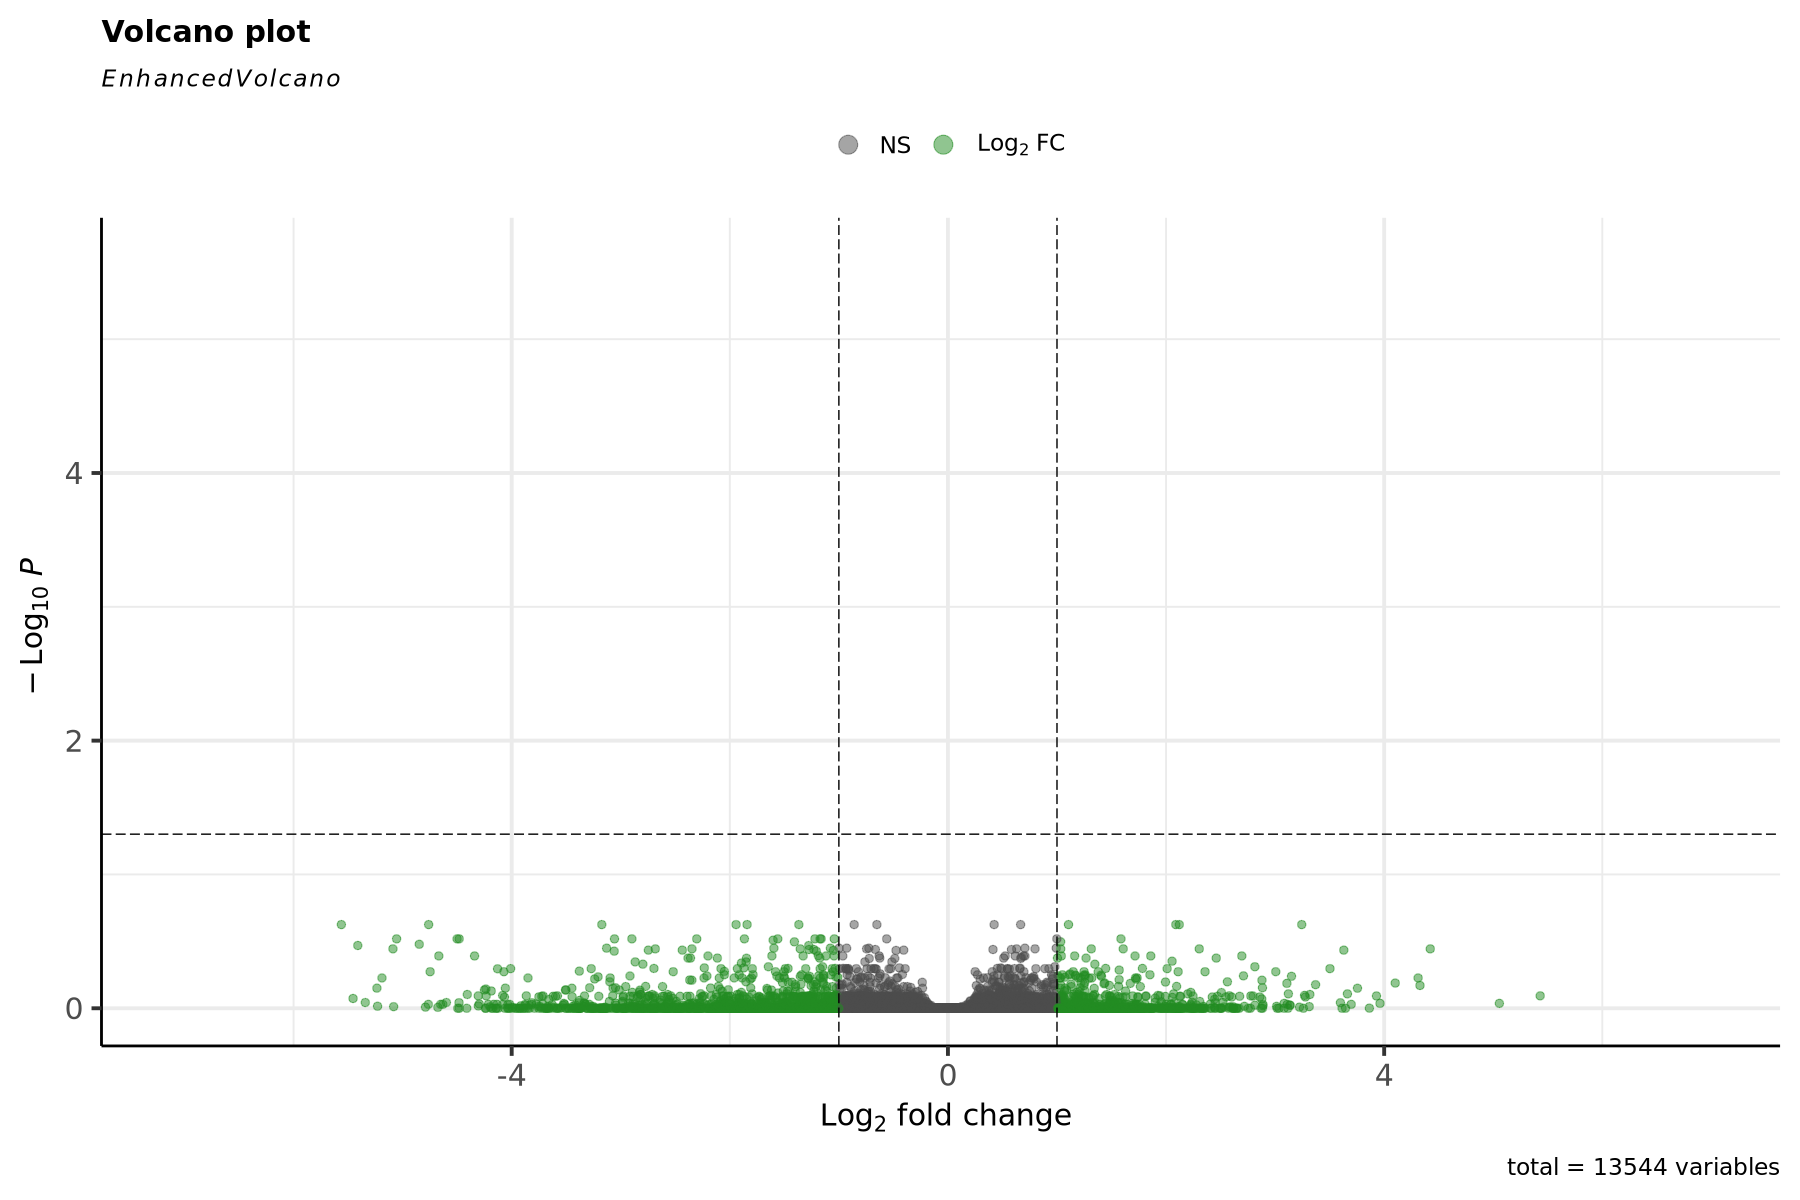

In [62]:
# phase 1 hypoxic vs. control
summary(results1)

EnhancedVolcano(results1, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

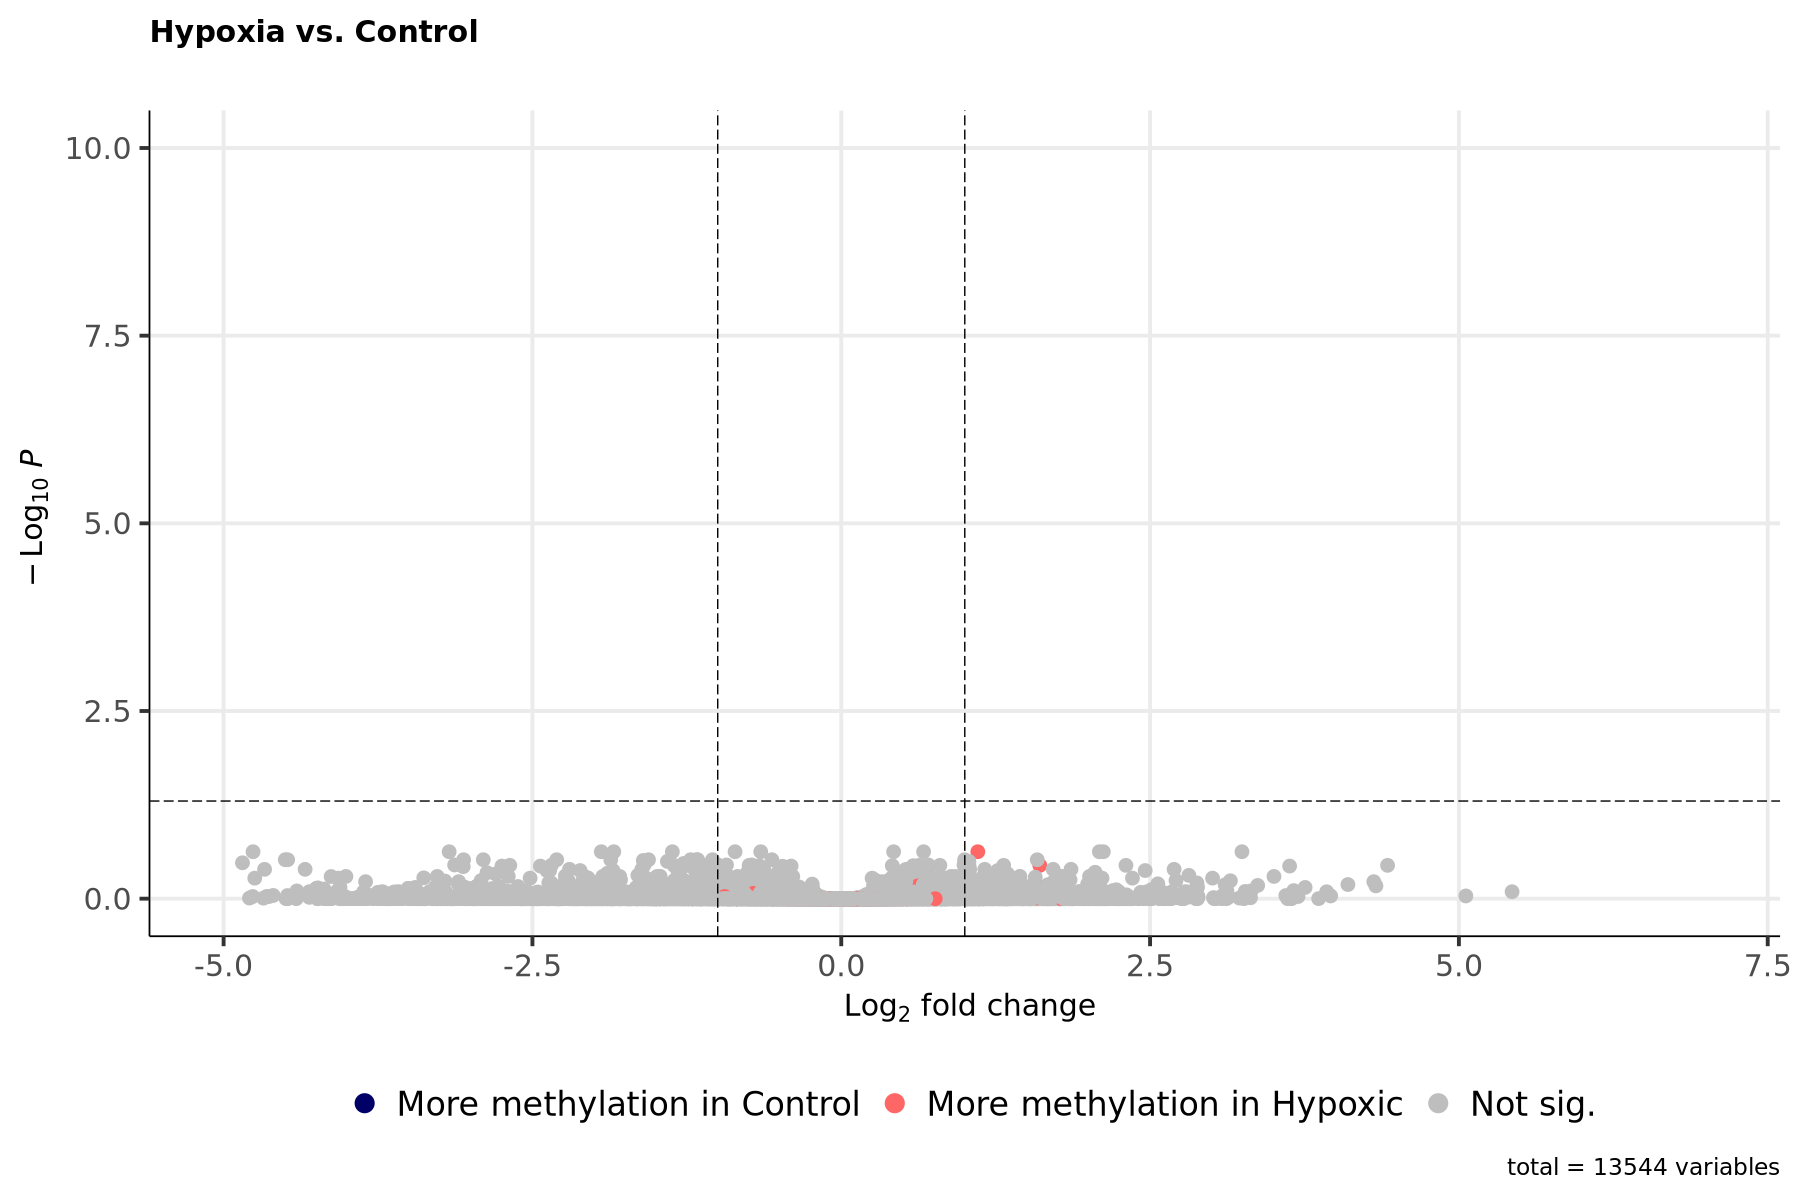

In [84]:
# creating 'prettier' more detailed plot
keyvals <- ifelse(
results1$log2FoldChange < -1& results3$padj <0.05, "#000066",
  ifelse(results3$log2FoldChange > 1& results3$padj <0.05,"#FF6666" ,
    'grey'))
keyvals[is.na(keyvals)] <- 'grey'
names(keyvals)[keyvals == "#FF6666"] <- 'More methylation in Hypoxic'
names(keyvals)[keyvals == 'grey'] <- 'Not sig.'
names(keyvals)[keyvals == "#000066"] <- 'More methylation in Control'

results1_plot <- EnhancedVolcano(results1,
    lab = NA, title = 'Hypoxia vs. Control', subtitle = '',
    x = 'log2FoldChange',
    y = 'padj', 
    selectLab = rownames(results1)[which(names(keyvals) %in% c('More methylation in Hypoxic', 'More methylation in Control'))],
    xlab = bquote(~Log[2]~ 'fold change'),
    pointSize = 3.5,
    pCutoff = 0.05, # and have our p-value cutoff to 0.05
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'bottom',
    legendLabSize = 20,
    legendIconSize = 5.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'black',
    arrowheads = FALSE,
    gridlines.major = TRUE,
    gridlines.minor = FALSE,
    border = 'partial',
    borderWidth = 0.5,
    borderColour = 'black', xlim=c(-5,7), ylim=c(0,10))
results1_plot

seeing no real difference in methylation of genes between samples that were hypoxic or control for phase 1


out of 13538 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 290, 2.1%
low counts [2]     : 6, 0.044%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



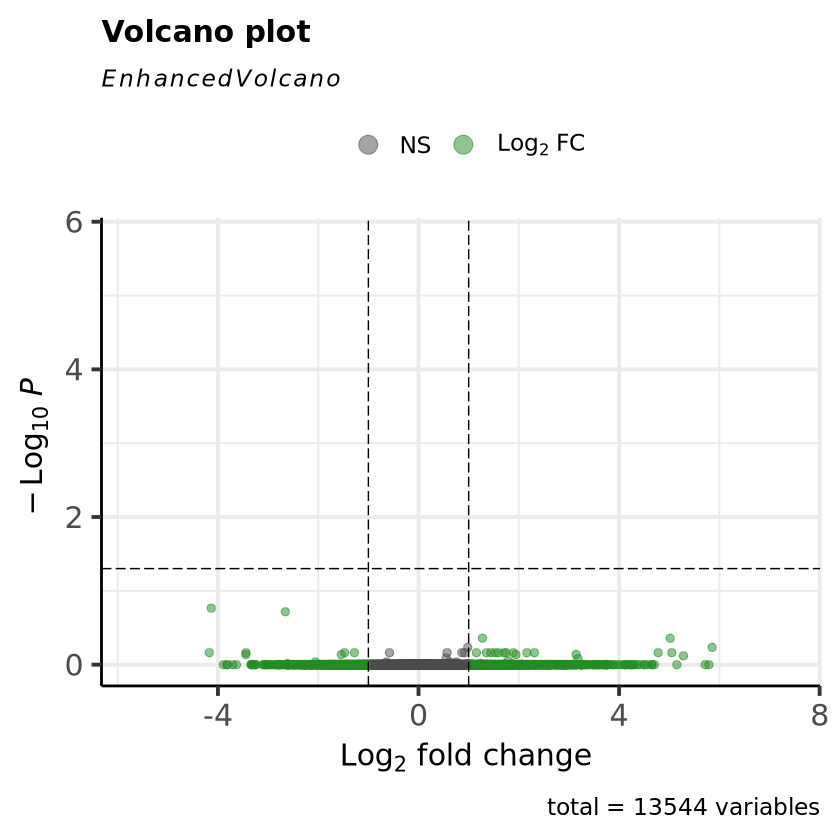

In [29]:
# phase 1 both vs. control
summary(results2)

EnhancedVolcano(results2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

same thing, no real difference between the two treatments for phase 1


out of 13538 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 655, 4.8%
LFC < 0 (down)     : 19, 0.14%
outliers [1]       : 290, 2.1%
low counts [2]     : 4960, 37%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



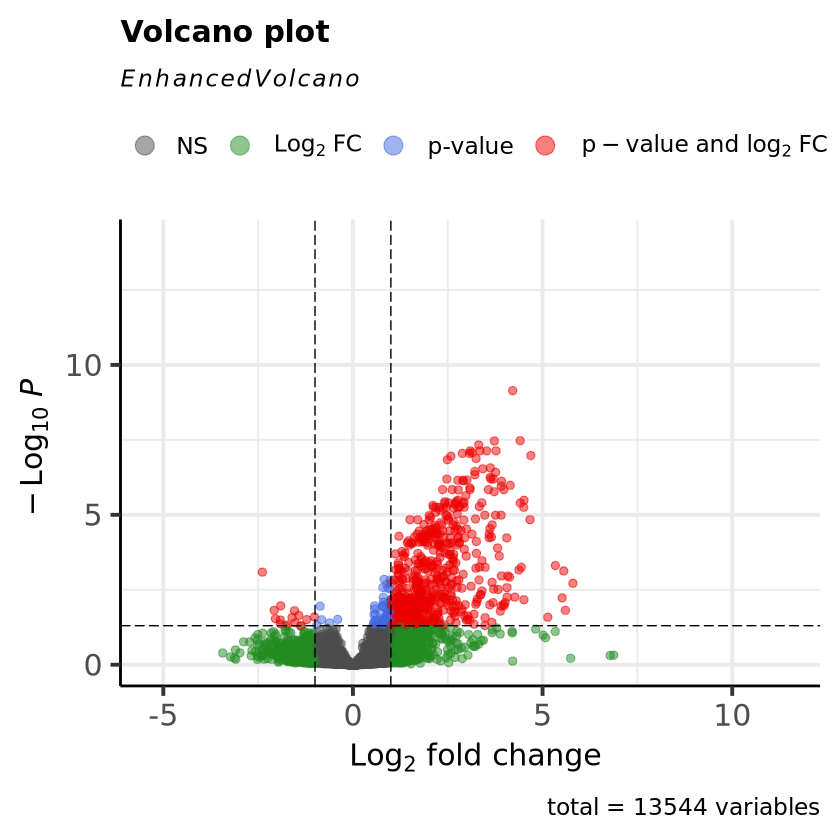

In [30]:
# phase 1 warm vs. control
summary(results3)

EnhancedVolcano(results3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05,
               FCcutoff=1)

so now we're starting to see a difference! seeing more methylation for samples that were warm for phase 1, compared those that were in ambient (control) conditions for phase 1

HOWEVER, looking at the meta data column, all of the control samples were hypoxic or control for phase 2, and all of the warm samples were both for phase 2, so idk if you can really compare these ...)

for Log2FoldChange filtering (lfcThreshold argument in DESeq results function) - don't think this matters since our downstream analysis is for GSEA (gene set enrichment analysis; also don't think that filtering should be done post hoc either...)

there's been talk online that you *should* filter for |log2foldchange| > 1 because if it's significant (p < 0.05) but is not a big change, probably won't be biologically relevant. But, on the flip side, if we're looking at pathways, maybe it doesn't have a huge change between samples, but contribute to the change in a pathway. 

In [31]:
# saving list of genes into csv file
write.csv(as.data.frame(results3), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/FC_sig_p1wc.csv')

making a prettier plot to use for my slides for NSA

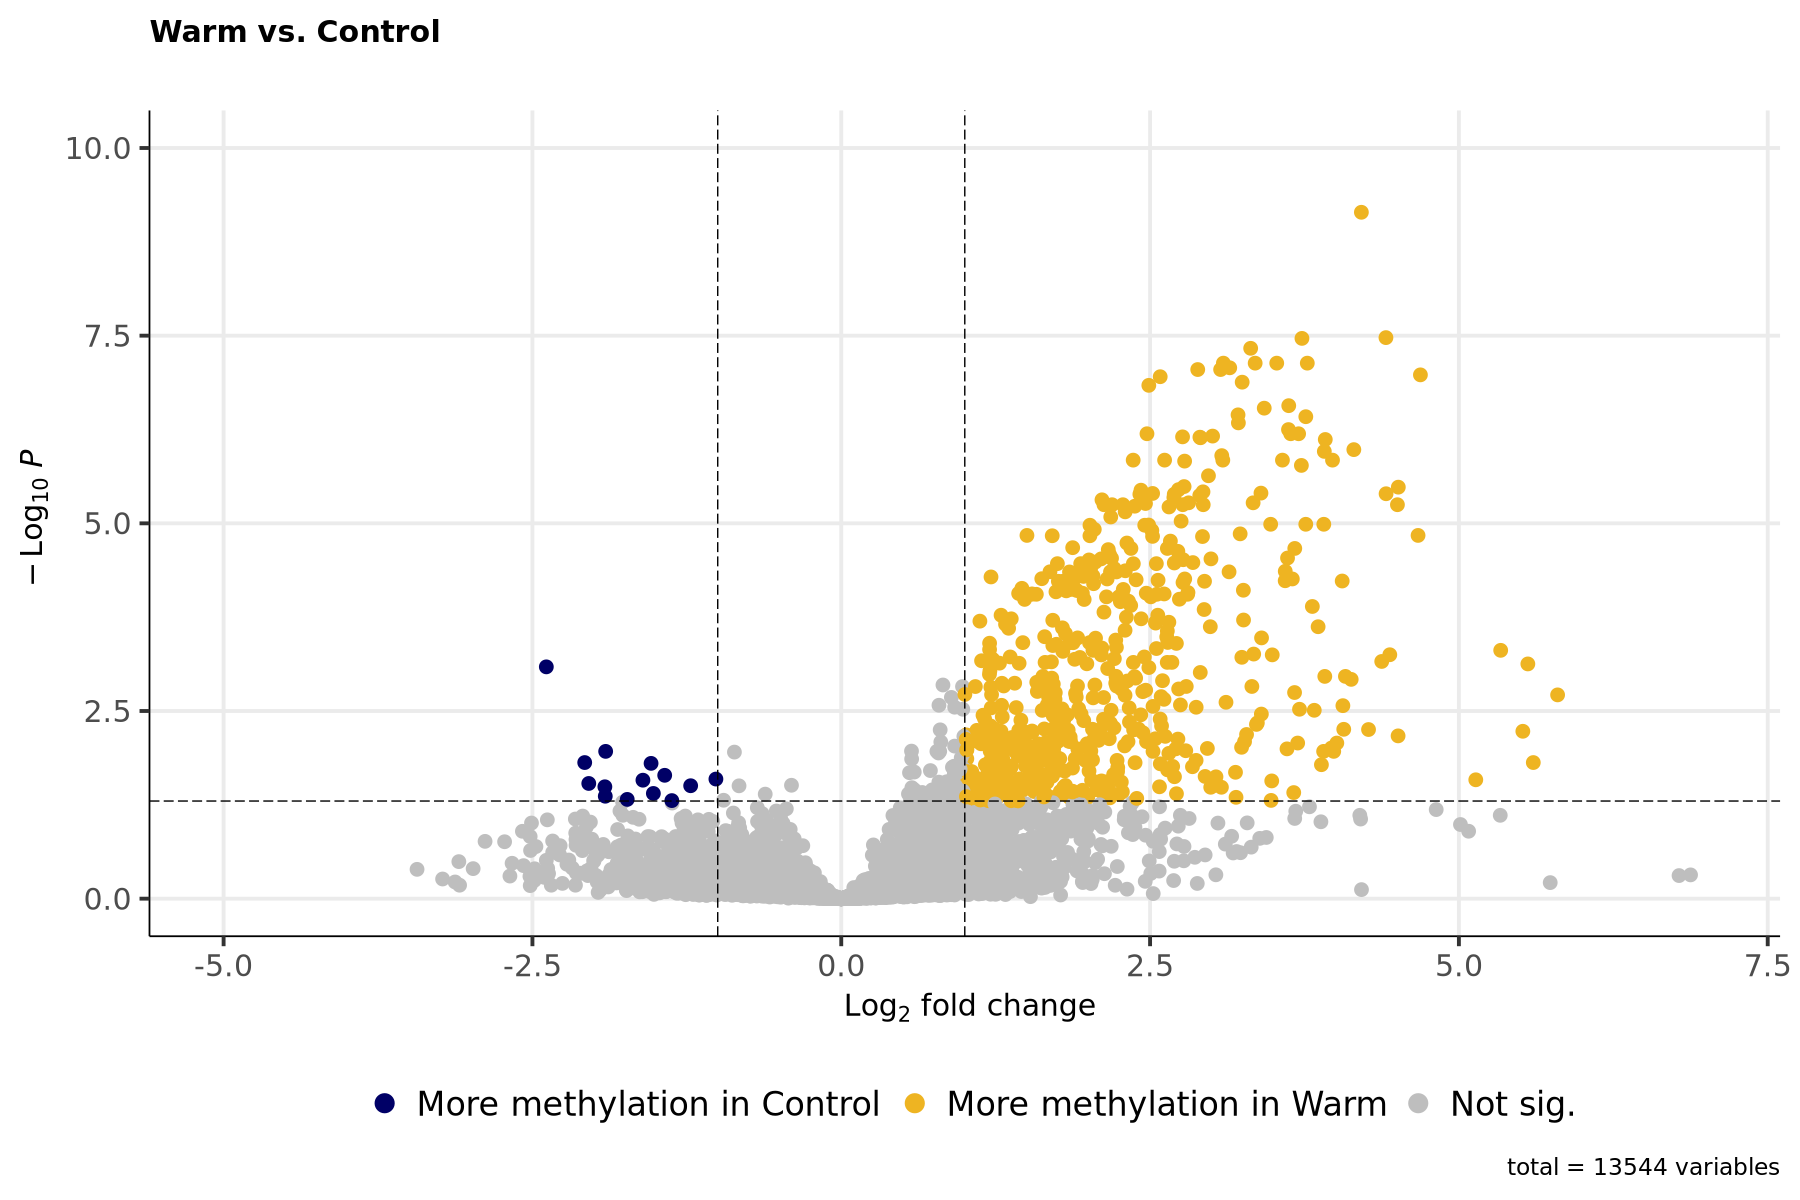

In [85]:
# creating 'prettier' more detailed plot
keyvals <- ifelse(
results3$log2FoldChange < -1& results3$padj <0.05, "#000066",
  ifelse(results3$log2FoldChange > 1& results3$padj <0.05,"goldenrod2" ,
    'grey'))
keyvals[is.na(keyvals)] <- 'grey'
names(keyvals)[keyvals == "goldenrod2"] <- 'More methylation in Warm'
names(keyvals)[keyvals == 'grey'] <- 'Not sig.'
names(keyvals)[keyvals == "#000066"] <- 'More methylation in Control'

results3_plot <- EnhancedVolcano(results3,
    lab = NA, title = 'Warm vs. Control', subtitle = '',
    x = 'log2FoldChange',
    y = 'padj', # so we are using padj...
    selectLab = rownames(results3)[which(names(keyvals) %in% c('More methylation in Warm', 'More methylation in Control'))],
    xlab = bquote(~Log[2]~ 'fold change'),
    pointSize = 3.5,
    pCutoff = 0.05, # and have our p-value cutoff to 0.05
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'bottom',
    legendLabSize = 20,
    legendIconSize = 5.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'black',
    arrowheads = FALSE,
    gridlines.major = TRUE,
    gridlines.minor = FALSE,
    border = 'partial',
    borderWidth = 0.5,
    borderColour = 'black', xlim=c(-5,7), ylim=c(0,10))
results3_plot

#### Effects of phase 2, ignoring phase 1

In [32]:
# checking to see what options we have for phase 2 samples
unique(meta_data$Phase2)

[1] "control" "hypoxic" "both"

In [33]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = fc_meta,
                              colData = meta_data, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 913 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase2_control_vs_both" "Phase2_hypoxic_vs_both"

In [34]:
# specify contrasts (what treatments to compare)
contrast4 <- c("Phase2", "hypoxic", "both")
contrast5 <- c("Phase2", "both", "control")

In [35]:
# storing results in variables to call for EnhancedVolcano 

# Phase 2 hypoxic vs. both
results4 <- results(p2_dds, contrast = contrast4, alpha=0.05)

# Phase 2 both vs. control
results5 <- results(p2_dds, contrast = contrast5, alpha=0.05)



out of 13538 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 8, 0.059%
LFC < 0 (down)     : 150, 1.1%
outliers [1]       : 0, 0%
low counts [2]     : 8930, 66%
(mean count < 13)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



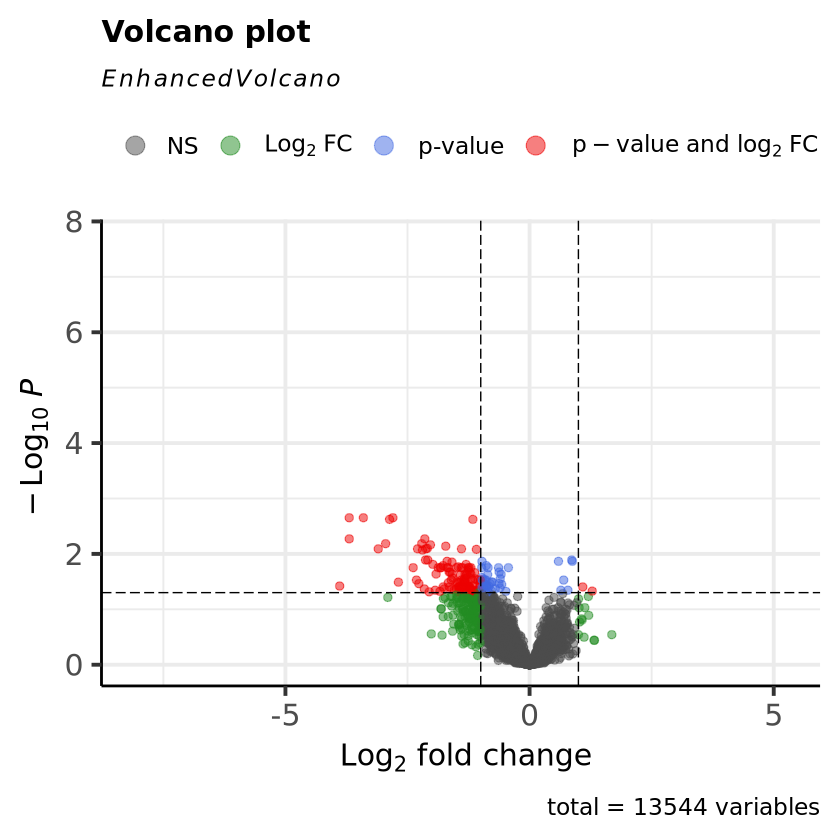

In [36]:
# phase 2 hypoxic vs. both
summary(results4)

EnhancedVolcano(results4, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

seeing more methylated genes in both samples compared to hypoxic samples for phase 2?


out of 13538 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 350, 2.6%
LFC < 0 (down)     : 48, 0.35%
outliers [1]       : 0, 0%
low counts [2]     : 5255, 39%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



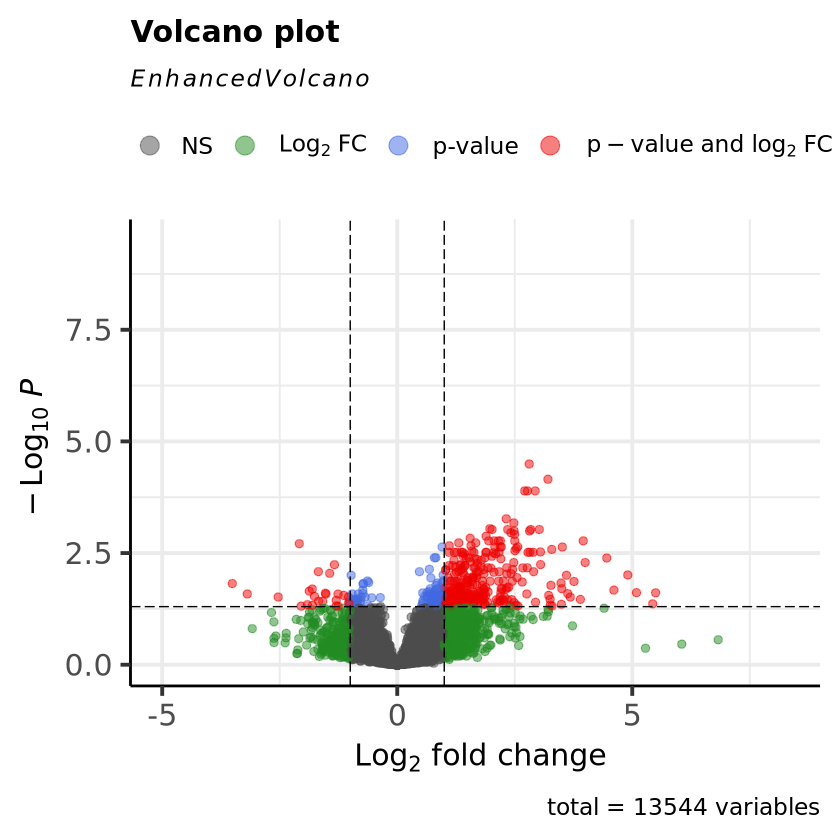

In [37]:
# phase 2 both vs. control
summary(results5)

EnhancedVolcano(results5, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

so - seeing about 350 genes that are sig. diff. methylated for samples in both for phase 2, and 44 genes for control for phase 2

#### Given phase 2, what are the effects of phase 1?
first looking at samples that were **hypoxic for phase 2**

grabbing only samples that were hypoxic for phase 2, and doing DESeq2 on phase 1

In [38]:
# for phase 2 hypoxic
p2hypoxic_meta = filter(meta_data, meta_data$Phase2 == 'hypoxic')
p2hypoxic_meta 

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BBO-BBO-B16,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
BBO-BBY-B27,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
BBR-BBB-B50,2018--BBR-BBB-B50-CV,BBR-BBB-B50,BBR,BBB,B50,hypoxic,ambient,R,hypoxic,ambient,B,hypoxic,hypoxic
BBR-BBG-B38,2018--BBR-BBG-B38-CV,BBR-BBG-B38,BBR,BBG,B38,hypoxic,ambient,R,hypoxic,ambient,G,hypoxic,hypoxic
BBR-BBY-B26,2018--BBR-BBY-B26-CV,BBR-BBY-B26,BBR,BBY,B26,hypoxic,ambient,R,hypoxic,ambient,Y,hypoxic,hypoxic
WBG-BBB-W56,2018--WBG-BBB-W56-CV,WBG-BBB-W56,WBG,BBB,W56,normoxic,ambient,G,hypoxic,ambient,B,control,hypoxic
WBO-BBR-W03,2018--WBO-BBR-W03-CV,WBO-BBR-W03,WBO,BBR,W03,normoxic,ambient,O,hypoxic,ambient,R,control,hypoxic
WBR-BBY-W25,2018--WBR-BBY-W25-CV,WBR-BBY-W25,WBR,BBY,W25,normoxic,ambient,R,hypoxic,ambient,Y,control,hypoxic
WBY-BBV-W65,2018--WBY-BBV-W65-CV,WBY-BBV-W65,WBY,BBV,W65,normoxic,ambient,Y,hypoxic,ambient,V,control,hypoxic


In [39]:
# have to make sure counts matrix has the same columns as rows in meta
p2hypoxic_counts = fc_meta[,colnames(fc_meta) %in% p2hypoxic_meta$unique_ID, drop=FALSE]
head(p2hypoxic_counts)

,BBO-BBO-B16,BBO-BBY-B27,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,WBG-BBB-W56,WBO-BBR-W03,WBR-BBY-W25,WBY-BBV-W65,WBY-BBY-W30
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,0,0,0,0,1,1,0,0,0,1
LOC111109452,0,0,10,12,0,1,0,0,1,2
LOC111124802,408,244,187,336,311,455,20,122,289,202
LOC111101273,115,75,64,115,137,127,8,43,87,81
LOC111101250,257,118,115,141,184,261,7,91,254,109
LOC111101262,502,364,246,389,355,485,40,184,387,251


In [40]:
p2h_dds <- DESeqDataSetFromMatrix(countData = p2hypoxic_counts,
                              colData = p2hypoxic_meta, 
                              design = ~ Phase1)
p2h_dds=DESeq(p2h_dds)
resultsNames(p2h_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"


out of 13371 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 7, 0.052%
LFC < 0 (down)     : 16, 0.12%
outliers [1]       : 190, 1.4%
low counts [2]     : 4825, 36%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



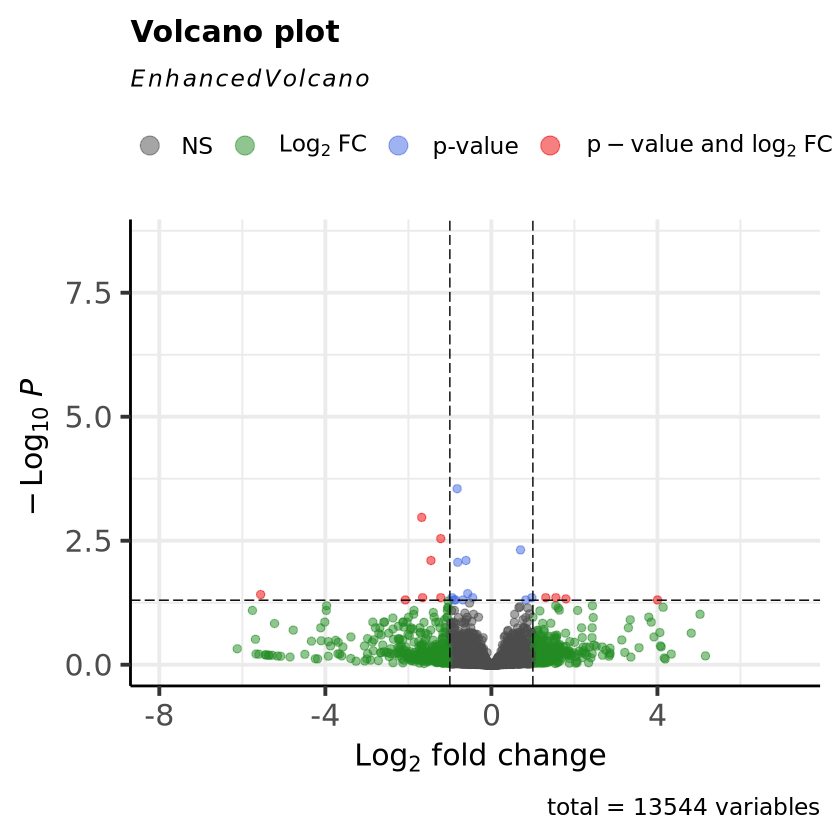

In [41]:
# phase 2 = hypoxic, looking at hypoxic vs. control for phase 1
res_p2h=results(p2h_dds, name="Phase1_hypoxic_vs_control", alpha = 0.05)

summary(res_p2h)
   
EnhancedVolcano(res_p2h,
                lab=NA,
                x = 'log2FoldChange',
                y = 'padj', pCutoff=0.05)

not a huge difference between these - seeing a little bit more methylation in control samples for phase 2 compared to hypoxic

(remember all of these were hypoxic for phase 2)

so when samples experience hypoxic for phase 2, there is slightly more methylation in samples that were control in phase 1

for samples that were **both for phase 2**

In [42]:
# for phase 2 both
p2both_meta = filter(meta_data, meta_data$Phase2 == 'both')
p2both_meta  

# have to make sure counts matrix has the same columns as rows in meta
p2both_counts = fc_meta[,colnames(fc_meta) %in% p2both_meta$unique_ID, drop=FALSE]
head(p2both_counts)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BPO-BPO-O16,2018--BPO-BPO-O16-CV,BPO-BPO-O16,BPO,BPO,O16,hypoxic,warm,O,hypoxic,warm,O,both,both
BPR-BPG-O38,2018--BPR-BPG-O38-CV,BPR-BPG-O38,BPR,BPG,O38,hypoxic,warm,R,hypoxic,warm,G,both,both
BPR-BPR-O02,2018--BPR-BPR-O02-CV,BPR-BPR-O02,BPR,BPR,O02,hypoxic,warm,R,hypoxic,warm,R,both,both
BPY-BPG-O42,2018--BPY-BPG-O42-CV,BPY-BPG-O42,BPY,BPG,O42,hypoxic,warm,Y,hypoxic,warm,G,both,both
BPY-BPY-O29,2018--BPY-BPY-O29-CV,BPY-BPY-O29,BPY,BPY,O29,hypoxic,warm,Y,hypoxic,warm,Y,both,both
WPB-BPG-G45,2018--WPB-BPG-G45-CV,WPB-BPG-G45,WPB,BPG,G45,normoxic,warm,B,hypoxic,warm,G,warm,both
WPO-BPO-G16,2018--WPO-BPO-G16-CV,WPO-BPO-G16,WPO,BPO,G16,normoxic,warm,O,hypoxic,warm,O,warm,both
WPO-BPY-G28,2018--WPO-BPY-G28-CV,WPO-BPY-G28,WPO,BPY,G28,normoxic,warm,O,hypoxic,warm,Y,warm,both
WPR-BPY-G25,2018--WPR-BPY-G25-CV,WPR-BPY-G25,WPR,BPY,G25,normoxic,warm,R,hypoxic,warm,Y,warm,both


,BPO-BPO-O16,BPR-BPG-O38,BPR-BPR-O02,BPY-BPG-O42,BPY-BPY-O29,WPB-BPG-G45,WPO-BPO-G16,WPO-BPY-G28,WPR-BPY-G25,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,1,0,2,1,1,0,0,1,1,0
LOC111109452,1,0,0,0,1,15,0,0,3,0
LOC111124802,56,245,45,33,120,168,134,86,252,9
LOC111101273,15,83,16,5,27,71,52,38,73,1
LOC111101250,25,132,28,12,42,92,49,5,101,2
LOC111101262,67,220,55,46,76,188,131,78,283,12


In [43]:
p2both_dds <- DESeqDataSetFromMatrix(countData = p2both_counts,
                              colData = p2both_meta, 
                              design = ~ Phase1)
p2both_dds=DESeq(p2both_dds)
resultsNames(p2both_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"           "Phase1_warm_vs_both"


out of 12941 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 80, 0.62%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 457, 3.5%
low counts [2]     : 11966, 92%
(mean count < 54)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



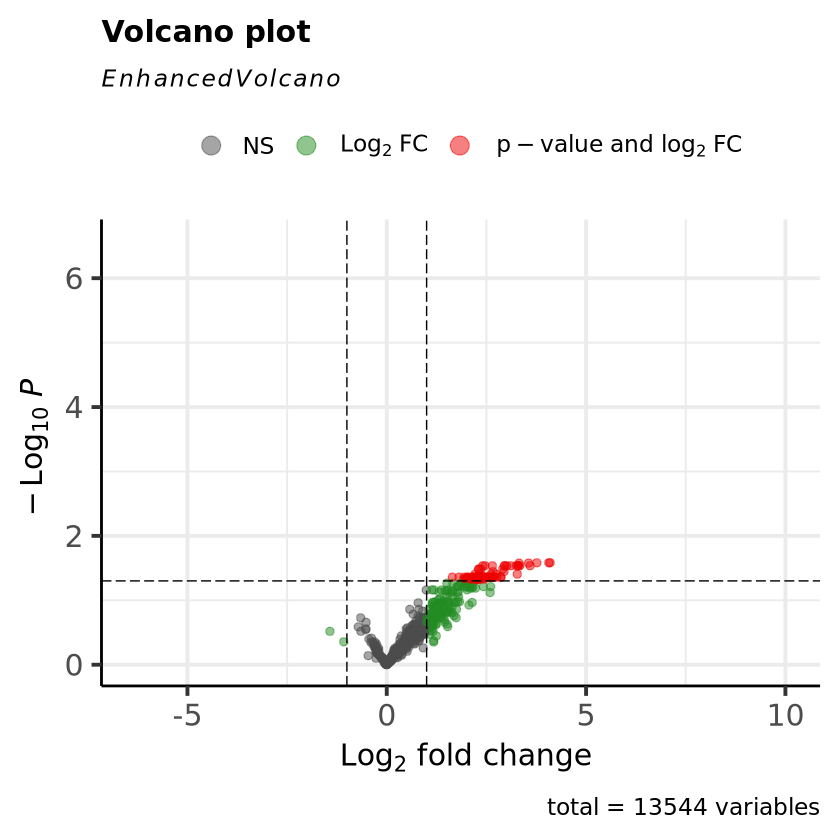

In [44]:
# phase 1 effects (warm vs. both) given phase 2 (both)
res_p2b=results(p2both_dds, name="Phase1_warm_vs_both", alpha = 0.05)

summary(res_p2b)
   
EnhancedVolcano(res_p2b,
                lab=NA,
                x = 'log2FoldChange',
                y = 'padj', pCutoff=0.05)

when samples experienced both stressors in phase 2, there's not a real difference between warm and both stressors for phase 1

for samples that were in **control/ambient conditions for phase 2**

In [45]:
# for phase 2 control
p2control_meta = filter(meta_data, meta_data$Phase2 == 'control')
p2control_meta  

# have to make sure counts matrix has the same columns as rows in meta
p2control_counts = fc_meta[,colnames(fc_meta) %in% p2control_meta$unique_ID, drop=FALSE]
head(p2control_counts)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BBB-WBO-B21,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
BBB-WBV-B70,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
BBO-WBO-B16,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
BBO-WBV-B64,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control
BBY-WBG-B42,2018--BBY-WBG-B42-CV,BBY-WBG-B42,BBY,WBG,B42,hypoxic,ambient,Y,normoxic,ambient,G,hypoxic,control
WBB-WBV-W69,2018--WBB-WBV-W69-CV,WBB-WBV-W69,WBB,WBV,W69,normoxic,ambient,B,normoxic,ambient,V,control,control
WBG-WBG-W44,2018--WBG-WBG-W44-CV,WBG-WBG-W44,WBG,WBG,W44,normoxic,ambient,G,normoxic,ambient,G,control,control
WBO-WBV-W64,2018--WBO-WBV-W64-CV,WBO-WBV-W64,WBO,WBV,W64,normoxic,ambient,O,normoxic,ambient,V,control,control
WBV-WBO-W23,2018--WBV-WBO-W23-CV,WBV-WBO-W23,WBV,WBO,W23,normoxic,ambient,V,normoxic,ambient,O,control,control


,BBB-WBO-B21,BBB-WBV-B70,BBO-WBO-B16,BBO-WBV-B64,BBY-WBG-B42,WBB-WBV-W69,WBG-WBG-W44,WBO-WBV-W64,WBV-WBO-W23,WBV-WBR-W12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,2,2,2,0,0,3,0,1,0,0
LOC111109452,0,0,1,1,2,0,0,7,1,0
LOC111124802,597,453,502,434,110,418,76,305,120,57
LOC111101273,173,146,171,158,45,132,49,143,45,18
LOC111101250,253,255,327,269,49,212,56,201,96,24
LOC111101262,645,634,647,677,108,453,102,422,146,52


In [46]:
p2control_dds <- DESeqDataSetFromMatrix(countData = p2control_counts,
                              colData = p2control_meta, 
                              design = ~ Phase1)
p2control_dds=DESeq(p2control_dds)
resultsNames(p2control_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"


out of 13322 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 135, 1%
LFC < 0 (down)     : 156, 1.2%
outliers [1]       : 286, 2.1%
low counts [2]     : 4491, 34%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



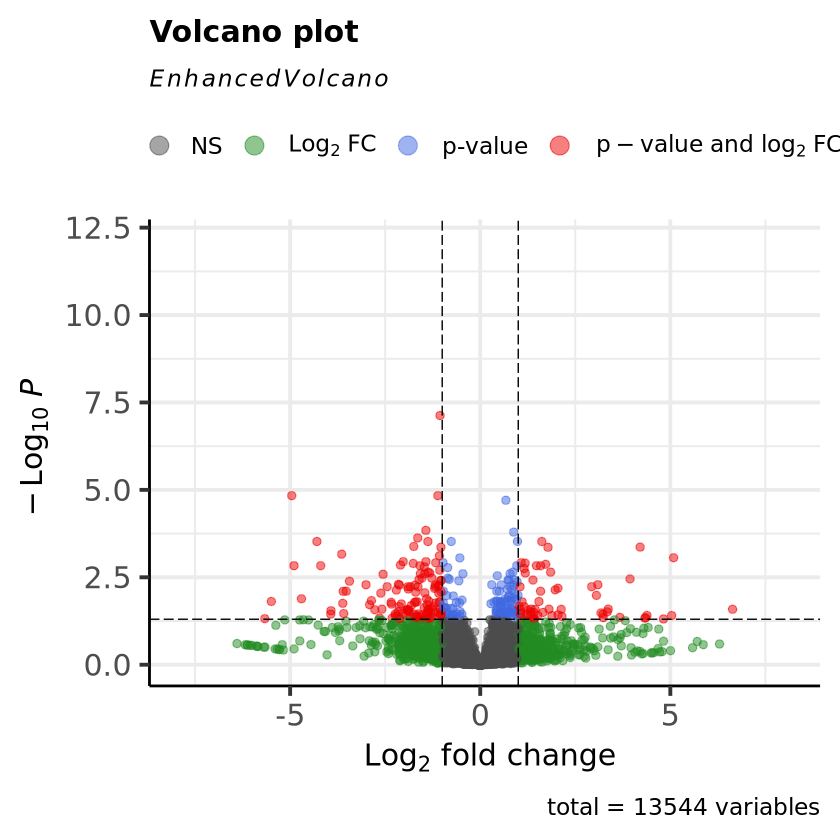

In [47]:
# effects of phase 1 (hypoxic vs. control), given phase 2 (control)
res_p2c=results(p2control_dds, name="Phase1_hypoxic_vs_control", alpha=0.05)

summary(res_p2c)
   
EnhancedVolcano(res_p2c,
                lab=NA,
                x = 'log2FoldChange',
                y = 'padj', pCutoff=0.05)

this is really interesting... when all samples are ambient conditions for phase 2, hypoxia has a large effect on methylation/ there seems to be a lot of differential methylation

when ambient (control) for phase 2:
- 131 methylated genes in hypoxic stress for phase 1
- 158 methylated genes in control for phase 1

#### Given the effects of phase 1, what are the effects of phase 2?
for samples that were **hypoxic for phase 1**

In [48]:
unique(meta_data$Phase1)

[1] "hypoxic" "both"    "control" "warm"

In [49]:
# for phase 1 hypoxic
p1hypoxic_meta = filter(meta_data, meta_data$Phase1 == 'hypoxic')
p1hypoxic_meta  

# have to make sure counts matrix has the same columns as rows in meta
p1hypoxic_counts = fc_meta[,colnames(fc_meta) %in% p1hypoxic_meta$unique_ID, drop=FALSE]
head(p1hypoxic_counts)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BBB-WBO-B21,2018--BBB-WBO-B21-CV,BBB-WBO-B21,BBB,WBO,B21,hypoxic,ambient,B,normoxic,ambient,O,hypoxic,control
BBB-WBV-B70,2018--BBB-WBV-B70-CV,BBB-WBV-B70,BBB,WBV,B70,hypoxic,ambient,B,normoxic,ambient,V,hypoxic,control
BBO-BBO-B16,2018--BBO-BBO-B16-CV,BBO-BBO-B16,BBO,BBO,B16,hypoxic,ambient,O,hypoxic,ambient,O,hypoxic,hypoxic
BBO-BBY-B27,2018--BBO-BBY-B27-CV,BBO-BBY-B27,BBO,BBY,B27,hypoxic,ambient,O,hypoxic,ambient,Y,hypoxic,hypoxic
BBO-WBO-B16,2018--BBO-WBO-B16-CV,BBO-WBO-B16,BBO,WBO,B16,hypoxic,ambient,O,normoxic,ambient,O,hypoxic,control
BBO-WBV-B64,2018--BBO-WBV-B64-CV,BBO-WBV-B64,BBO,WBV,B64,hypoxic,ambient,O,normoxic,ambient,V,hypoxic,control
BBR-BBB-B50,2018--BBR-BBB-B50-CV,BBR-BBB-B50,BBR,BBB,B50,hypoxic,ambient,R,hypoxic,ambient,B,hypoxic,hypoxic
BBR-BBG-B38,2018--BBR-BBG-B38-CV,BBR-BBG-B38,BBR,BBG,B38,hypoxic,ambient,R,hypoxic,ambient,G,hypoxic,hypoxic
BBR-BBY-B26,2018--BBR-BBY-B26-CV,BBR-BBY-B26,BBR,BBY,B26,hypoxic,ambient,R,hypoxic,ambient,Y,hypoxic,hypoxic


,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,2,2,0,0,2,0,0,0,1,0
LOC111109452,0,0,0,0,1,1,10,12,0,2
LOC111124802,597,453,408,244,502,434,187,336,311,110
LOC111101273,173,146,115,75,171,158,64,115,137,45
LOC111101250,253,255,257,118,327,269,115,141,184,49
LOC111101262,645,634,502,364,647,677,246,389,355,108


In [50]:
p1hypoxic_dds <- DESeqDataSetFromMatrix(countData = p1hypoxic_counts,
                              colData = p1hypoxic_meta, 
                              design = ~ Phase2)
p1hypoxic_dds=DESeq(p1hypoxic_dds)
resultsNames(p1hypoxic_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"


out of 13397 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 663, 4.9%
LFC < 0 (down)     : 468, 3.5%
outliers [1]       : 302, 2.3%
low counts [2]     : 3570, 27%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



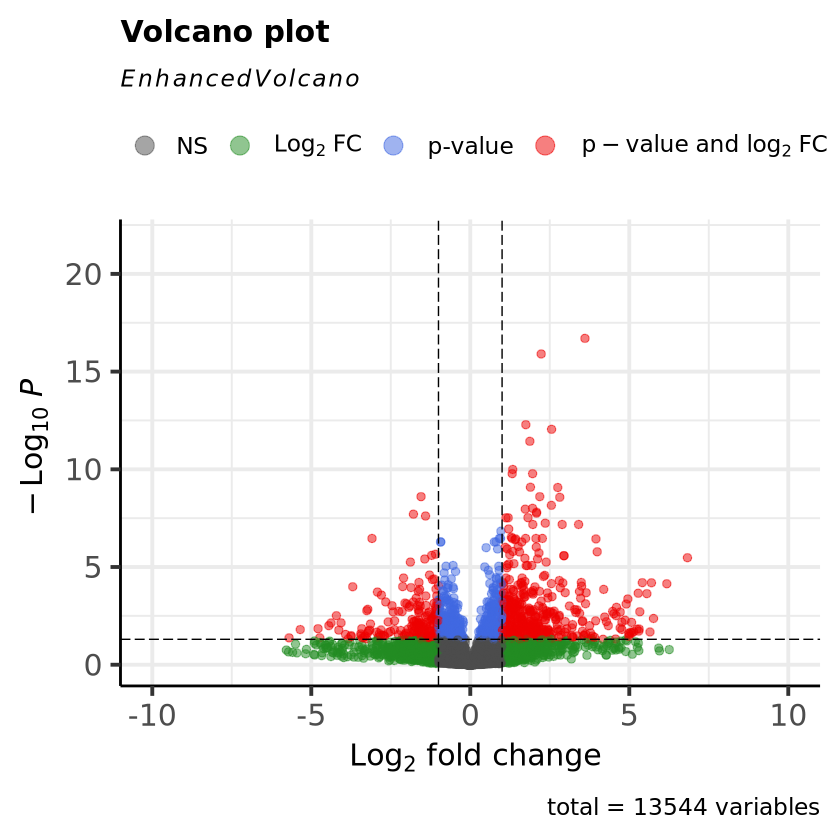

In [51]:
# effects of phase 2 (hypoxic vs. control), given phase 1 (hypoxic)
res_p1h=results(p1hypoxic_dds, name="Phase2_hypoxic_vs_control", alpha=0.05)

summary(res_p1h)
   
EnhancedVolcano(res_p1h,
                lab=NA,
                x = 'log2FoldChange',
                y = 'padj', pCutoff=0.05, FCcutoff=1, xlim=c(-10,10))

super interesting results - when samples experience hypoxic stress for phase 1, there's a lot of differences in methylation, but there seems to be more methylation when the samples experience hypoxic stress again in phase 2 - evidence of carryover effects?? it seems the hypoxic stress 'primed' them...

In [52]:
options(repr.plot.width=15, repr.plot.height=10)

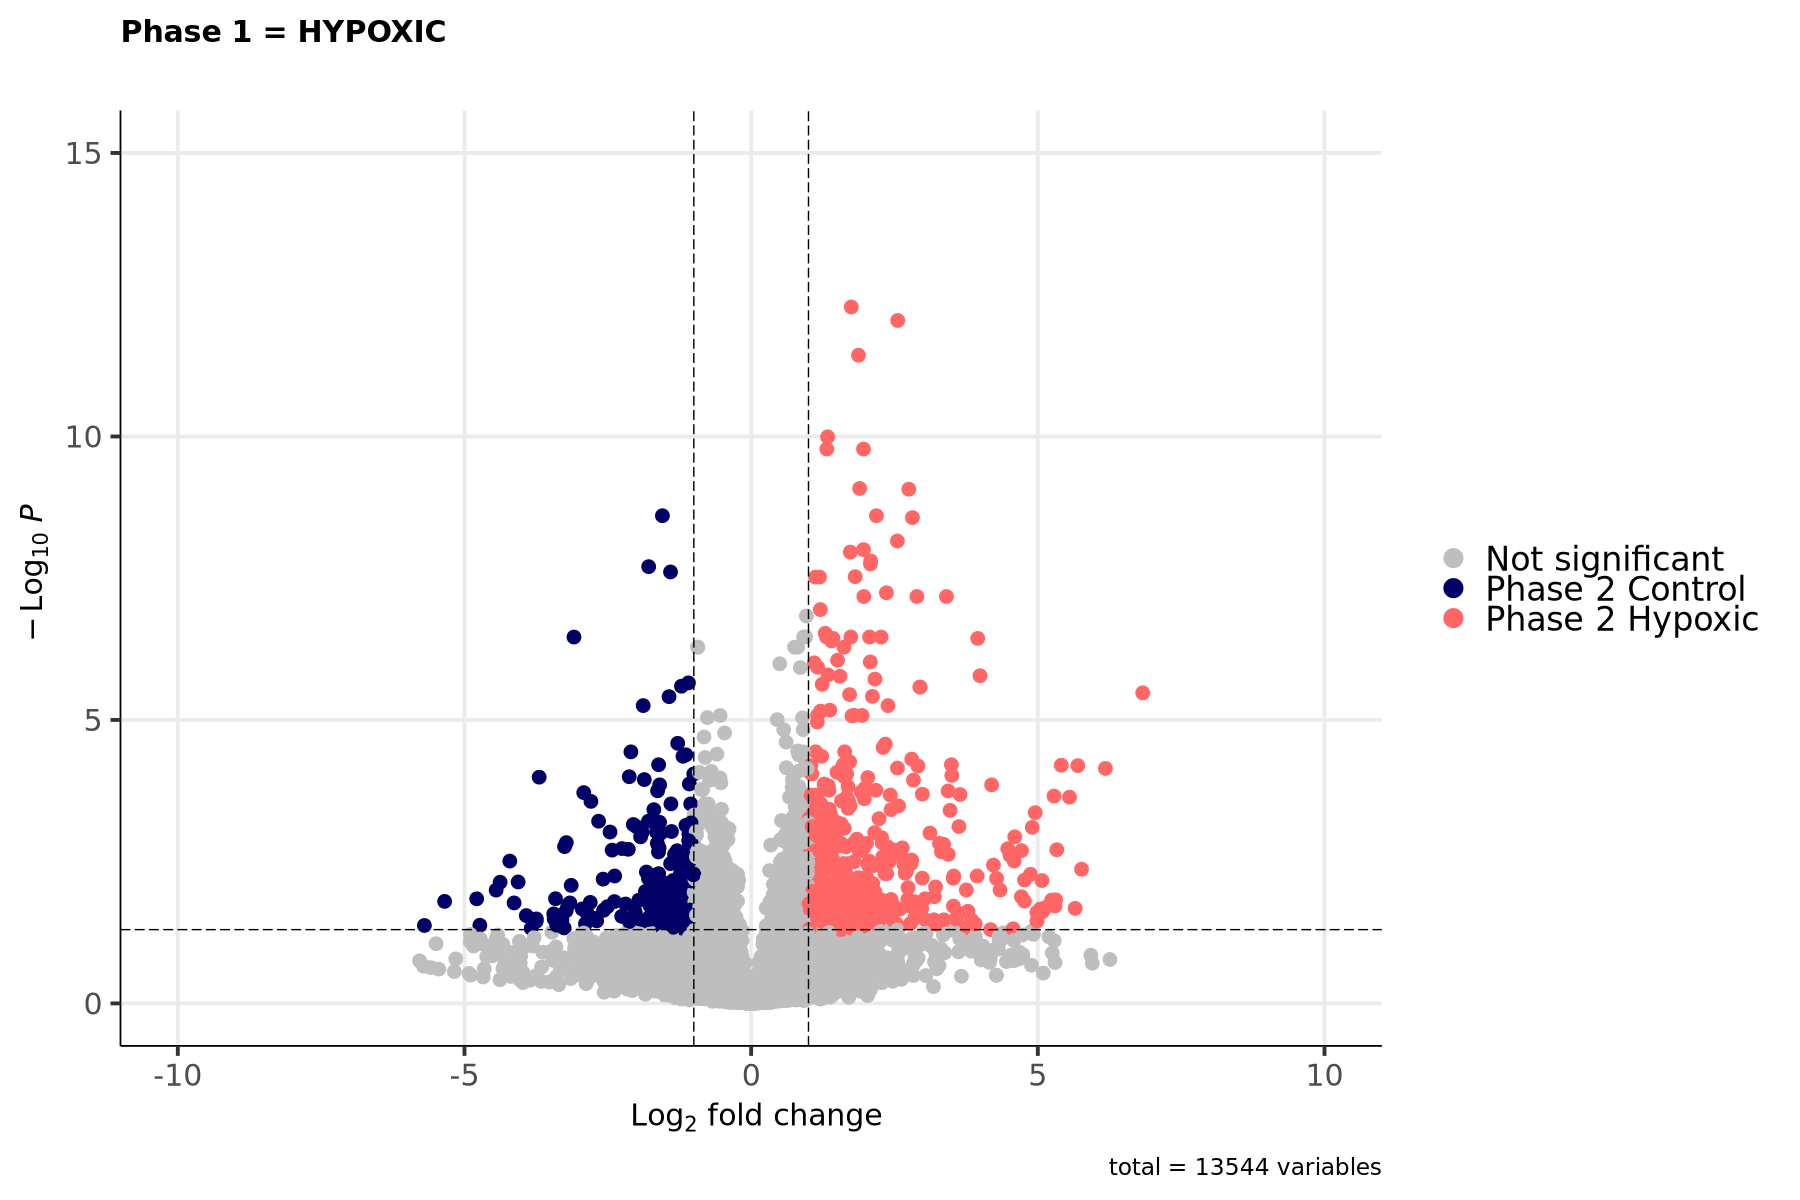

In [53]:
# creating 'prettier' more detailed plot
keyvals <- ifelse(
res_p1h$log2FoldChange < -1& res_p1h$padj <0.05, "#000066",
  ifelse(res_p1h$log2FoldChange > 1& res_p1h$padj <0.05,"#FF6666" ,
    'grey'))
keyvals[is.na(keyvals)] <- 'grey'
names(keyvals)[keyvals == "#FF6666"] <- 'Phase 2 Hypoxic'
names(keyvals)[keyvals == 'grey'] <- 'Not significant'
names(keyvals)[keyvals == "#000066"] <- 'Phase 2 Control'

res_p1h_plot <- EnhancedVolcano(res_p1h,
    lab = NA, title = 'Phase 1 = HYPOXIC', subtitle = '',
    x = 'log2FoldChange',
    y = 'padj', # so we are using padj...
    selectLab = rownames(res_p1h)[which(names(keyvals) %in% c('Phase 2 Hypoxic', 'Phase 2 Control'))],
    xlab = bquote(~Log[2]~ 'fold change'),
    pointSize = 3.5,
    pCutoff = 0.05, # and have our p-value cutoff to 0.05
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'right',
    legendLabSize = 20,
    legendIconSize = 5.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'black',
    arrowheads = FALSE,
    gridlines.major = TRUE,
    gridlines.minor = FALSE,
    border = 'partial',
    borderWidth = 0.5,
    borderColour = 'black', xlim=c(-10,10),ylim=c(0,15))
res_p1h_plot

samples that were both for phase 1 were only both for phase 2 - so can't do any specific comparison for those samples/treatments

samples that were warm for phase 1 were only both for phase 2 - so again, can't do any analysis there

#### for samples that were **control for phase 1**

In [54]:
# for phase 1 control
p1control_meta = filter(meta_data, meta_data$Phase1 == 'control')
p1control_meta  

# have to make sure counts matrix has the same columns as rows in meta
p1control_counts = fc_meta[,colnames(fc_meta) %in% p1control_meta$unique_ID, drop=FALSE]
head(p1control_meta)

,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WBB-WBV-W69,2018--WBB-WBV-W69-CV,WBB-WBV-W69,WBB,WBV,W69,normoxic,ambient,B,normoxic,ambient,V,control,control
WBG-BBB-W56,2018--WBG-BBB-W56-CV,WBG-BBB-W56,WBG,BBB,W56,normoxic,ambient,G,hypoxic,ambient,B,control,hypoxic
WBG-WBG-W44,2018--WBG-WBG-W44-CV,WBG-WBG-W44,WBG,WBG,W44,normoxic,ambient,G,normoxic,ambient,G,control,control
WBO-BBR-W03,2018--WBO-BBR-W03-CV,WBO-BBR-W03,WBO,BBR,W03,normoxic,ambient,O,hypoxic,ambient,R,control,hypoxic
WBO-WBV-W64,2018--WBO-WBV-W64-CV,WBO-WBV-W64,WBO,WBV,W64,normoxic,ambient,O,normoxic,ambient,V,control,control
WBR-BBY-W25,2018--WBR-BBY-W25-CV,WBR-BBY-W25,WBR,BBY,W25,normoxic,ambient,R,hypoxic,ambient,Y,control,hypoxic
WBV-WBO-W23,2018--WBV-WBO-W23-CV,WBV-WBO-W23,WBV,WBO,W23,normoxic,ambient,V,normoxic,ambient,O,control,control
WBV-WBR-W12,2018--WBV-WBR-W12-CV,WBV-WBR-W12,WBV,WBR,W12,normoxic,ambient,V,normoxic,ambient,R,control,control
WBY-BBV-W65,2018--WBY-BBV-W65-CV,WBY-BBV-W65,WBY,BBV,W65,normoxic,ambient,Y,hypoxic,ambient,V,control,hypoxic


,sample_ID,unique_ID,T1_code,T2_code,ID_code,T1_oxygen,T1_temp,Tank1,T2_oxygen,T2_temp,Tank2,Phase1,Phase2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WBB-WBV-W69,2018--WBB-WBV-W69-CV,WBB-WBV-W69,WBB,WBV,W69,normoxic,ambient,B,normoxic,ambient,V,control,control
WBG-BBB-W56,2018--WBG-BBB-W56-CV,WBG-BBB-W56,WBG,BBB,W56,normoxic,ambient,G,hypoxic,ambient,B,control,hypoxic
WBG-WBG-W44,2018--WBG-WBG-W44-CV,WBG-WBG-W44,WBG,WBG,W44,normoxic,ambient,G,normoxic,ambient,G,control,control
WBO-BBR-W03,2018--WBO-BBR-W03-CV,WBO-BBR-W03,WBO,BBR,W03,normoxic,ambient,O,hypoxic,ambient,R,control,hypoxic
WBO-WBV-W64,2018--WBO-WBV-W64-CV,WBO-WBV-W64,WBO,WBV,W64,normoxic,ambient,O,normoxic,ambient,V,control,control
WBR-BBY-W25,2018--WBR-BBY-W25-CV,WBR-BBY-W25,WBR,BBY,W25,normoxic,ambient,R,hypoxic,ambient,Y,control,hypoxic


In [55]:
p1control_dds <- DESeqDataSetFromMatrix(countData = p1control_counts,
                              colData = p1control_meta, 
                              design = ~ Phase2)
p1control_dds=DESeq(p1control_dds)
resultsNames(p1control_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [64]:
# effects of phase 1 (hypoxic vs. control), given phase 2 (control)
res_p1c=results(p1control_dds, name="Phase2_hypoxic_vs_control", alpha=0.05)

summary(res_p1c)
   
EnhancedVolcano(res_p1c,
                lab=NA,
                x = 'log2FoldChange',
                y = 'padj', pCutoff=0.05)

ERROR: Error in results(p1control_dds, name = "Phase2_hypoxic_vs_control", alpha = 0.05): couldn't find results. you should first run DESeq()


In [ ]:
# creating 'prettier' more detailed plot
keyvals <- ifelse(
res_p1c$log2FoldChange < -1& res_p1c$padj <0.05, "#000066",
  ifelse(res_p1c$log2FoldChange > 1& res_p1c$padj <0.05,"#FF6666" ,
    'grey'))
keyvals[is.na(keyvals)] <- 'grey'
names(keyvals)[keyvals == "#FF6666"] <- 'Phase 2 Hypoxic'
names(keyvals)[keyvals == 'grey'] <- 'Not significant'
names(keyvals)[keyvals == "#000066"] <- 'Phase 2 Control'

res_p1c_plot <- EnhancedVolcano(res_p1c,
    lab = NA, title = 'Phase 1 = CONTROL', subtitle = '',
    x = 'log2FoldChange',
    y = 'padj', # so we are using padj...
    selectLab = rownames(res_p1c)[which(names(keyvals) %in% c('Phase 2 Hypoxic', 'Phase 2 Control'))],
    xlab = bquote(~Log[2]~ 'fold change'),
    pointSize = 3.5,
    pCutoff = 0.05, # and have our p-value cutoff to 0.05
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'right', 
    legendLabSize = 25,
    legendIconSize = 5.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'black',
    arrowheads = FALSE,
    gridlines.major = TRUE,
    gridlines.minor = FALSE,
    border = 'partial',
    borderWidth = 0.5,
    borderColour = 'black', xlim=c(-10,10), ylim=c(0,15))
res_p1c_plot

In [65]:
#BiocManager::install('cowplot')
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
legend_title <- ggdraw() + draw_label("More methylation in:", fontface = 'bold', size = 15)
legend <- get_legend(res_p1c_plot)
combined_plot <- plot_grid(res_p1c_plot + guides(color = FALSE), res_p1h_plot + guides(color = FALSE), legend, labels = "AUTO", align = "h", axis='l', ncol = 3, rel_widths = c(1, 1, 0.7))
combined_plot

In [ ]:
# saving 'pretty', unfiltered plot as PDF
# Open a pdf file
setwd("/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures")
pdf("ce_control_hypoxic.pdf", width=15, height=10) 
# 2. Create a plot
combined_plot
# Close the pdf filegb
dev.off() 

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
legend_title <- ggdraw() + draw_label("More methylation in:", fontface = 'bold', size = 15)
legend <- get_legend(res_p1c_plot)
combined_plot <- plot_grid(res_p1c_plot + guides(color = FALSE), res_p1h_plot, labels = "AUTO", align = "v", axis='b', ncol = 2, rel_widths = c(1, 1.5))
combined_plot

In [ ]:
# adding title to entire plot
title <- ggdraw() + 
  draw_label(
    "Evidence of DNA Methylation as a Mechanism of Carryover Effects",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )
plot_grid(
  title, combined_plot,
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)

putting results1_plot (hypoxia vs. control for phase 1) and results3_plot (warm vs. control for phase 1) on the same grid like above, using cowplot

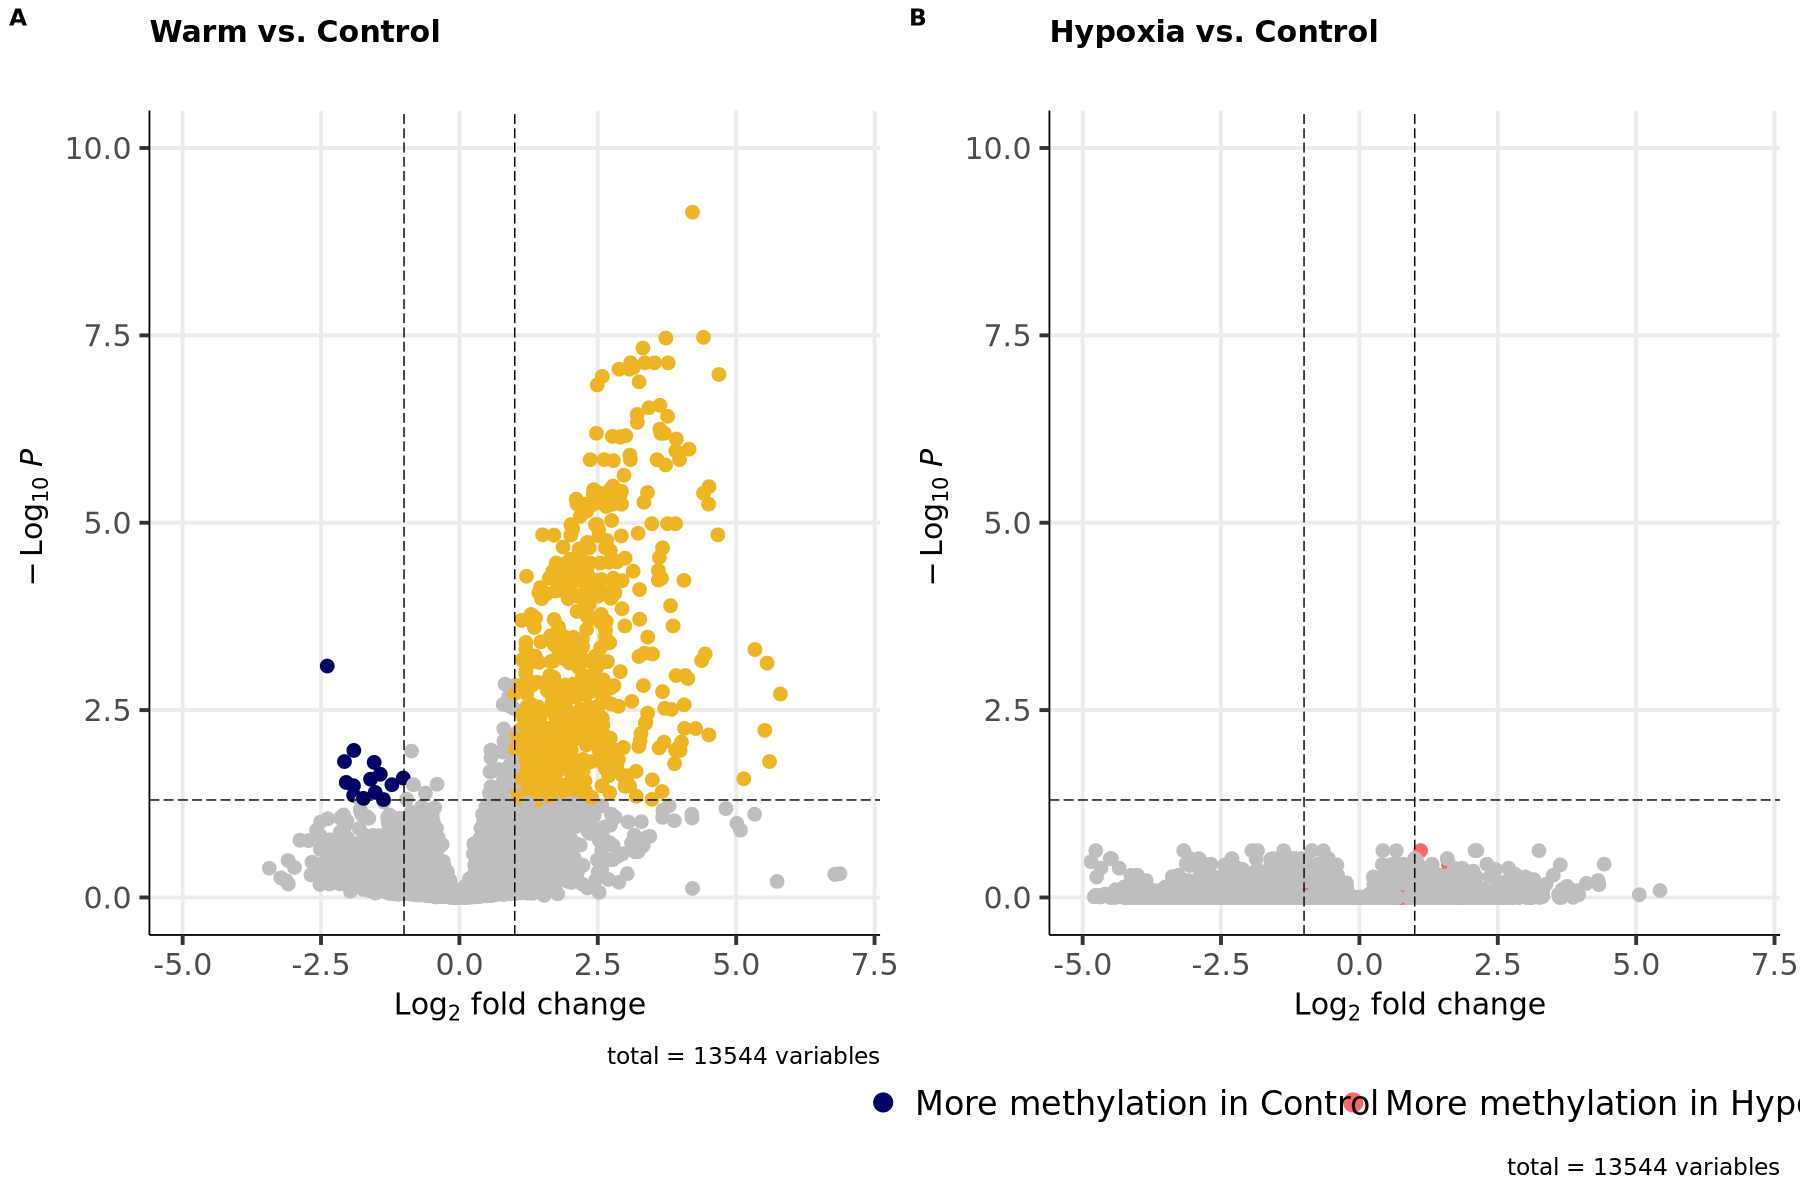

In [86]:
options(repr.plot.width=15, repr.plot.height=10)
#legend_title <- ggdraw() + draw_label("More methylation in:", fontface = 'bold', size = 15)
#legend <- get_legend(res_p1c_plot)
combined_plot <- plot_grid(results3_plot+ guides(color = FALSE), results1_plot, labels = "AUTO", align = "h", axis='b', ncol = 2, rel_widths = c(1, 1))
combined_plot

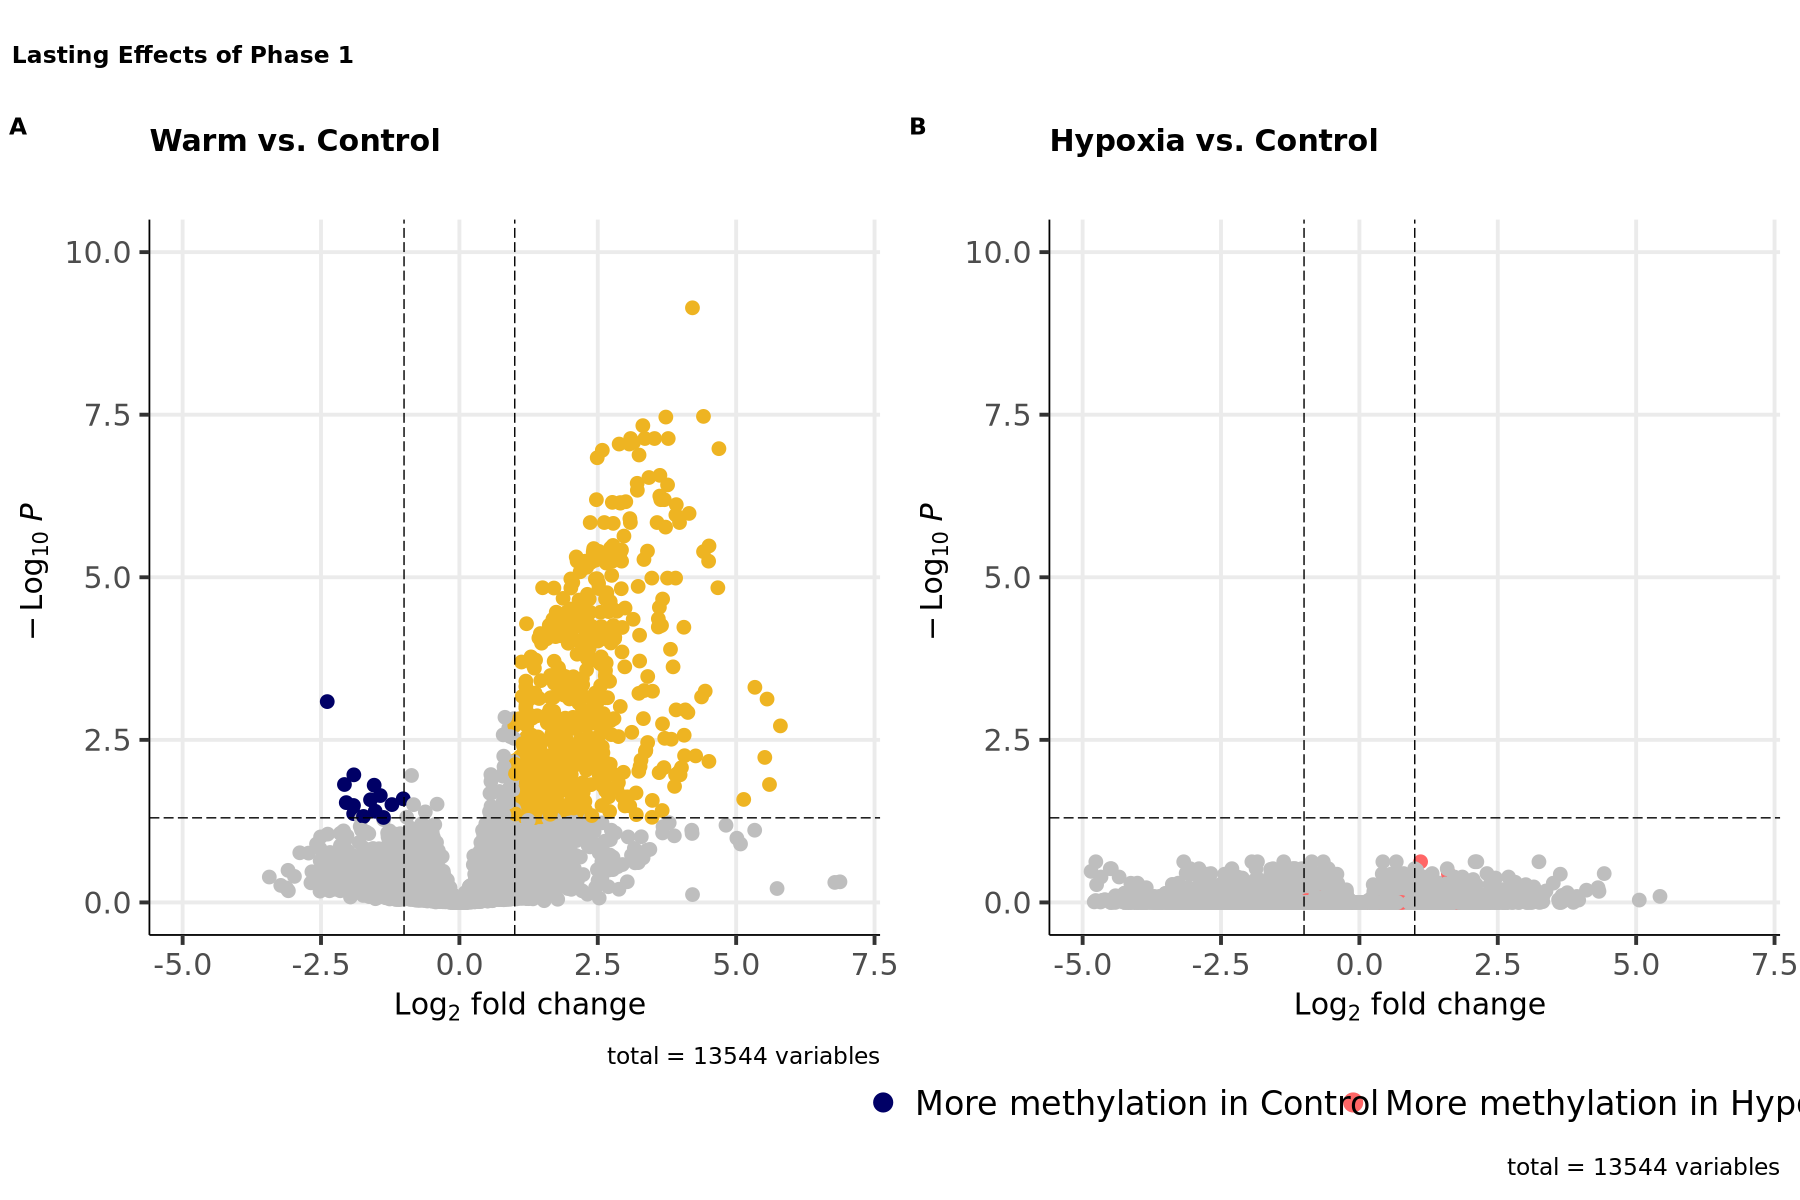

In [87]:
# adding title to entire plot
title <- ggdraw() + 
  draw_label(
    "Lasting Effects of Phase 1",
    fontface = 'bold',
    x = 0,
    hjust = 0
  ) +
  theme(
    # add margin on the left of the drawing canvas,
    # so title is aligned with left edge of first plot
    plot.margin = margin(0, 0, 0, 7)
  )
plot_grid(
  title, combined_plot,
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(0.1, 1)
)